In [1]:
import os
import math
import torch
from torch import nn
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import DataLoader
import lightning as L
import pytorch_lightning as pl
import datasets
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from IPython.display import display, HTML
from pprint import pprint
from dotenv import load_dotenv
from datasets import DatasetDict
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib_inline.backend_inline
from pathlib import Path
from lightning.pytorch.loggers import TensorBoardLogger

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
sns.set()

%load_ext tensorboard
%matplotlib inline

/home/dwalker/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
import io
import sys
from IPython.display import display, HTML


class OutputCapturer:
    def __init__(self, height: int = 400):
        self.height = height
        self.output_buffer = io.StringIO()

    def __enter__(self):
        self.original_stdout = sys.stdout
        sys.stdout = self.output_buffer
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self.original_stdout
        output_text = self.output_buffer.getvalue()
        lines = output_text.splitlines()
        numbered_lines = [f"{i+1} | {line}" for i, line in enumerate(lines)]
        numbered_output = "\n".join(numbered_lines)
        html = f"""
        <div style="
            width: calc(100% - 40px);
            max-height: {self.height}px; 
            overflow: auto;
            background: rgb(0,0,0);
            background: linear-gradient(0deg, rgba(10,10,10,1) 0%, rgba(31,31,31,1) 100%);
            foreground-color: #E3D8F1;
            padding: 20px;
            font-family: Fira Code, monospace;
            font-size: 14pt;
            font-weight: 500;
            border: solid 2px #E3D8F1;
        ">
            <pre style="
                word-wrap: normal;   
            ">{output_text}</pre>
        </div>
        """
        display(HTML(html))

There are a lot of NLP datasets that we could use for training our embedding model. Navigating to the dataset section of HuggingFace's website you can find prepared datasets of various types including NLP, CV, and more. We will use the `wikimedia/wikipedia` dataset since it is not too large (~6,000,000 documents) and contains all english texts. This dataset also contains a healthy mixture of topics that should allow us to generate a fairly robust vocabulary.

We will use the `datasets` library from HuggingFace for convenience for this task. This API makes it easy to work with datasets and provides some tools for manipulating and sharing datasets.

Downloading the dataset is fairly easy, simply use the provided `load_dataset` function from the library and provide the reference to the dataset you want in the `organization/repository` format. We have included some extra information to select only the English documents since we are not training a multi-lingual embedding model. Setting `20231101.en` selects the English dataset curated on November 1, 2023. Since we do not want the extra reference and markdown information typically present in a Wikipedia article, the authors of the dataset have pre-processed the text and removed problematic tokens.

In [5]:
ds = load_dataset("wikimedia/wikipedia", "20231101.en")

Generating train split: 100%|██████████| 6407814/6407814 [01:11<00:00, 89080.90 examples/s] 


Since this dataset is large it will take quite some time to finish downloading depending on your connection speed. Printing the `ds` variable to the screen shows some basic information about the dataset.

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 6407814
    })
})

Notice that the type is a `DatasetDict`, this is a dictionary class that holds `Dataset` objects. In our case we only have a single `train` key as no validation/test sets have been created. We will create a test set in a moment. To get additional information we need to specify which dataset we wish to know more about, as we only have the one dataset we will use the `.info` attribute to extract the `DatasetInfo` object:

** Note: here we are using the `OutputCapturer` custom class (defined above) to make the output easier to read and parse. We are also using the built-in `pprint` function to format the dictionary object in an easier to read format. Throughout this notebook the same procedure will be done.

In [19]:
with OutputCapturer():
    pprint(ds['train'].info)

In the output we can see a `splits` key at the top-level that contains a single `train` key. In this `train` key we have a `shard_lengths` list. Since this dataset is quite large, it would be faster if we split up the dataset so that some pre-processing can be done in the background while the current batch of data is being operated on. This can be achieved through the process of sharding, more information about sharding can be found here:

https://www.digitalocean.com/community/tutorials/understanding-database-sharding


The `datasets` library provides a `train_test_split` method for splitting your dataset into a training and testing set. Since we have over 6,000,000 examples, we can choose a smaller test proportion of 5%. This will still yield ~300,000 testing examples which is more than enough to assess the embedding performance.

In [20]:
ds = ds['train'].train_test_split(test_size=0.05)

If we look at this `ds` object again we can see that it now has two keys, one for `train` and the other for our new `test` set. 

In [21]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 5478680
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 288352
    })
})

We can perform the same inspection as before, this time on each set:

In [22]:
with OutputCapturer(400):
    pprint(ds['train'].info), pprint(ds['test'].info)

Do you notice anything strange? The `DatasetInfo` object is the same as before! This is because that object is static and will always reference the original dataset.

Let's take a look at some of the samples. You can set the `batch_size` parameter below to control how many samples are displayed to the screen and set the `index` parameter to select which batch you want to inspect.

We will not make use of the other keys since we are not interested in the `url`, `title`, or `id` keys.

In [23]:
batch_size = 4
index = 0
sample = ds["train"][index : index + batch_size]["text"]
with OutputCapturer(height=400) as output:
    for i, s in enumerate(sample):
        print(f"Sample {i}: {s}", end="\n\n")

Now we can move on to creating our own tokenizer using the `Tokenizers` library.

## Tokenization


We cannot feed the sequences of words found in the dataset directly into the model. We need to translate each sequence into atomic units of language we call _tokens_.


It is important that the tokenizer used to train the model is also used for inference. If a different tokenizer is used then a word might be split in a way that is not expected by the model and will yield undesirable results. This is why in HuggingFace and other Machine Learning tools you will encounter tokenizers that are named after the model they are associated with (e.g. `T5Tokenizer`, `BERTTokenizer`, etc.). Just because a tokenizer was used to train a popular foundational language (such as BERT) doesn't mean you cannot use it for another NLP model if you are doing the pre-training of said model.


In [4]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

We will use a simple pre-tokenizer that splits on whitespace.


In [5]:
from tokenizers.pre_tokenizers import Whitespace

tokenizer.pre_tokenizer = Whitespace()

In [6]:
tokenizer.train_from_iterator(ds["train"]["text"], trainer=trainer)

In [28]:
tokenizer.save("models/tokenizer.json")

In [36]:
sentence = "Training a tokenizer is not hard when you have good libraries."
print(tokenizer.encode(sentence).tokens)

['T', 'raining', 'a', 'token', 'izer', 'is', 'not', 'hard', 'when', 'you', 'have', 'good', 'libraries', '.']


In [16]:
tokenizer_path = Path("models/tokenizer.json")
with open(tokenizer_path, "r") as f:
    tokenizer_json = f.read()

In [17]:
tokenizer2 = Tokenizer.from_str(tokenizer_json)

In [18]:
sentence = "Training a tokenizer is not hard when you have good libraries."
print(tokenizer2.encode(sentence).tokens)

['T', 'raining', 'a', 'token', 'izer', 'is', 'not', 'hard', 'when', 'you', 'have', 'good', 'libraries', '.']


In [35]:
sentence = ds["train"][0]["text"]
print(tokenizer.encode(sentence).tokens)

['One', 'day', ',', 'a', 'little', 'girl', 'named', 'Lily', 'found', 'a', 'needle', 'in', 'her', 'room', '.', 'She', 'knew', 'it', 'was', 'difficult', 'to', 'play', 'with', 'it', 'because', 'it', 'was', 'sharp', '.', 'Lily', 'wanted', 'to', 'share', 'the', 'needle', 'with', 'her', 'mom', ',', 'so', 'she', 'could', 'sew', 'a', 'button', 'on', 'her', 'shirt', '.', 'Lily', 'went', 'to', 'her', 'mom', 'and', 'said', ',', '"', 'Mom', ',', 'I', 'found', 'this', 'needle', '.', 'Can', 'you', 'share', 'it', 'with', 'me', 'and', 'sew', 'my', 'shirt', '?"', 'Her', 'mom', 'smiled', 'and', 'said', ',', '"', 'Yes', ',', 'Lily', ',', 'we', 'can', 'share', 'the', 'needle', 'and', 'fix', 'your', 'shirt', '."', 'Together', ',', 'they', 'shared', 'the', 'needle', 'and', 'sewed', 'the', 'button', 'on', 'Lily', "'", 's', 'shirt', '.', 'It', 'was', 'not', 'difficult', 'for', 'them', 'because', 'they', 'were', 'sharing', 'and', 'helping', 'each', 'other', '.', 'After', 'they', 'finished', ',', 'Lily', 'thank

In [ ]:
sentences = ds["train"][0:4]["text"]
encoded_batch = tokenizer.encode_batch(sentences)
with OutputCapturer() as capturer:
    for encoding in encoded_batch:
        print(encoding.tokens)

In [52]:
ds = load_dataset("roneneldan/TinyStories", split="train")

In [54]:
ds[0]

{'text': 'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'}

In [88]:
def encode(samples):
    return {"tokens": [b.tokens for b in tokenizer.encode_batch(samples["text"])]}

In [89]:
train_ds = ds.map(encode, batched=True, batch_size=2_048)

Map:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Map: 100%|██████████| 2119719/2119719 [05:59<00:00, 5902.74 examples/s]


In [239]:
ds = load_dataset("roneneldan/TinyStories", split="validation")

In [245]:
test_ds = ds.map(encode, batched=True, batch_size=2_048)

In [231]:
with OutputCapturer() as capturer:
    pprint(train_ds[0], compact=True)

In [251]:
dataset = DatasetDict({"train": train_ds, "test": test_ds})

In [223]:
!huggingface-cli login --token $HUGGINGFACE_TOKEN

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/dwalker/.cache/huggingface/token
Login successful


In [236]:
!yes | huggingface-cli repo create gpt4_short_stories_with_tokens --type dataset --organization athena-ml

git version 2.34.1
git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)

You are about to create datasets/athena-ml/gpt4_short_stories_with_tokens
Proceed? [Y/n] 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-66d7b06e-67e498be1aba9301452914f2;49df577c-64b3-453f-9854-f73051d02a35)

You already created this dataset repo
{"error":"You already created this dataset repo","url":"https://huggingface.co/datasets/athena-ml/gpt4_short_stories_with_tokens"}
yes: standard output: Broken pipe


In [252]:
dataset.push_to_hub("athena-ml/gpt4_short_stories_with_tokens")

Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/athena-ml/gpt4_short_stories_with_tokens/commit/09c90ea6803d3bade5c4764bb7df059122c36d9a', commit_message='Upload dataset', commit_description='', oid='09c90ea6803d3bade5c4764bb7df059122c36d9a', pr_url=None, pr_revision=None, pr_num=None)

In [19]:
pl.seed_everything(577)

Seed set to 577


577

In [21]:
NEIGHBORHOOD_SIZE = 2
BATCH_SIZE = 64

In [24]:
## Collation function for CBOW
chunk_size = NEIGHBORHOOD_SIZE * 2 + 1


def collate_fn(batch: list[str]) -> dict[str, list[torch.Tensor]]:
    batch_input, batch_output = [], []
    batch_encoding = tokenizer.encode_batch(batch)
    for encoding in batch_encoding:
        if len(encoding.ids) < chunk_size:
            continue
        seq_len = len(encoding.ids)
        n_possible_chunks = seq_len // chunk_size
        for i in range(0, n_possible_chunks * chunk_size, chunk_size):
            chunk = encoding.ids[i : i + chunk_size]
            output = chunk.pop(NEIGHBORHOOD_SIZE)
            batch_input.append(chunk)
            batch_output.append(output)

    batch_input = torch.tensor(batch_input)
    batch_output = torch.tensor(batch_output)

    return {"features": batch_input, "labels": batch_output}


In [60]:
train_dataset = load_dataset("roneneldan/TinyStories", split="train")
test_dataset = load_dataset("roneneldan/TinyStories", split="validation")
train_dl = DataLoader(
    train_dataset["text"], batch_size=BATCH_SIZE, collate_fn=collate_fn, pin_memory=True
)
test_dl = DataLoader(
    test_dataset["text"], batch_size=BATCH_SIZE, collate_fn=collate_fn, pin_memory=True
)

In [26]:
batch = test_dataset[0:5]["text"]
batch_encoding = tokenizer.encode_batch(batch)
with OutputCapturer() as capturer:
    for idx, encoding in enumerate(batch_encoding):
        print(f"seq {idx}: {encoding.ids}")

In [28]:
class W2V_CBOW(L.LightningModule):
    """Implements the Continuous Bag of Words Word2Vec model."""

    def __init__(
        self,
        tokenizer: Tokenizer = None,
        embedding_dim: int = 512,
        neighborhood_size: int = 2,
    ):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.tokenizer = tokenizer
        self.neighborhood_size = neighborhood_size
        self.chunk_size = self.neighborhood_size * 2 + 1
        self.vocab_size = tokenizer.get_vocab_size()
        self.projection_dim = embedding_dim
        self.projection_layer = nn.Embedding(
            num_embeddings=self.vocab_size, embedding_dim=embedding_dim, max_norm=1
        )
        self.linear_layer = nn.Linear(
            in_features=embedding_dim, out_features=self.vocab_size
        )

    def forward(self, x):
        x = self.projection_layer(x)
        x = x.mean(dim=1)
        x = self.linear_layer(x)
        return x

    def on_train_start(self):
        self.logger.log_hyperparams(
            self.hparams,
            {
                "hp/embed_dim": self.embedding_dim,
                "hp/neighborhood_size": self.neighborhood_size,
            },
        )

    def training_step(self, batch, batch_idx):
        y_hat = self(batch["features"])
        loss = F.cross_entropy(
            y_hat,
            batch["labels"],
        )
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plot_dl = DataLoader(
    test_dataset[0:4]["text"], batch_size=BATCH_SIZE, collate_fn=collate_fn
)

##############################################################


def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]
        sns.histplot(
            val_dict[key],
            ax=key_ax,
            color=color,
            bins=50,
            stat=stat,
            kde=use_kde and ((val_dict[key].max() - val_dict[key].min()) > 1e-8),
        )  # Only plot kde if there is variance
        hidden_dim_str = (
            r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0])
            if len(val_dict[key].shape) > 1
            else ""
        )
        key_ax.set_title(f"{key} {hidden_dim_str}")
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig


##############################################################


def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[0]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    # Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()


##############################################################


def visualize_gradients(model, color="C0", print_variance=False):
    """
    Args:
        net: Object of class BaseNetwork
        color: Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.to(device)
    model.eval()
    batch_dict = next(iter(plot_dl))
    features = batch_dict["features"].to(device)
    labels = batch_dict["labels"].to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(features)
    loss = F.cross_entropy(
        preds, labels
    )  # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {
        name: params.grad.view(-1).cpu().clone().numpy()
        for name, params in model.named_parameters()
        if "weight" in name
    }
    model.zero_grad()

    # Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")


##############################################################


def visualize_activations(model, color="C0", print_variance=False):
    model.to(device)
    model.eval()
    batch_dict = next(iter(plot_dl))
    features = batch_dict["features"].to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = features.view(features.shape[0], -1)
    activations = {}
    with torch.no_grad():
        _feats = model.projection_layer(feats)
        activations["Projection Layer"] = _feats.view(-1).detach().cpu().numpy()
        _feats = model.linear_layer(_feats)
        activations["Linear Layer"] = _feats.view(-1).detach().cpu().numpy()

    # Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

In [39]:
def const_init(model, fill=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(fill)

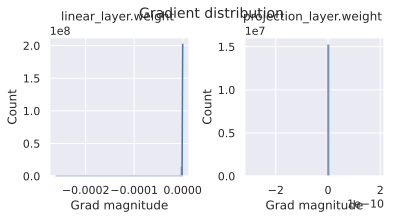

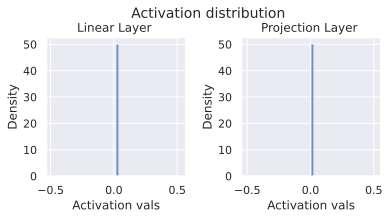

Linear Layer - Variance: 1.1618573399381493e-13
Projection Layer - Variance: 2.168404344971009e-19


In [40]:
model = W2V_CBOW(tokenizer=tokenizer)
const_init(model, fill=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

In [41]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(mean=0.0, std=std)

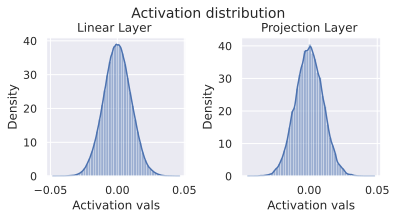

Linear Layer - Variance: 0.00010550046135904267
Projection Layer - Variance: 0.00010158694203710184


In [42]:
var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

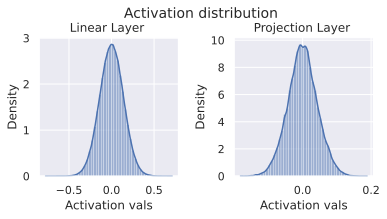

Linear Layer - Variance: 0.019478200003504753
Projection Layer - Variance: 0.0018425657181069255


In [43]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

In [45]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0 / math.sqrt(param.shape[1]))

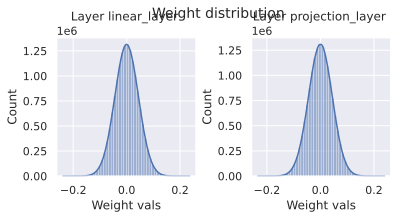

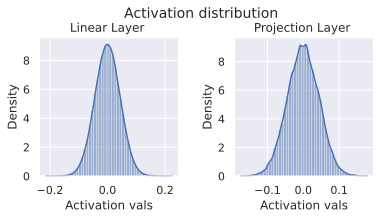

Linear Layer - Variance: 0.001913970336318016
Projection Layer - Variance: 0.00191507360432297


In [55]:
equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

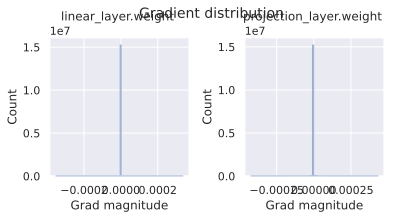

linear_layer.weight - Variance: 5.343182493677823e-12
projection_layer.weight - Variance: 5.49515771428033e-12


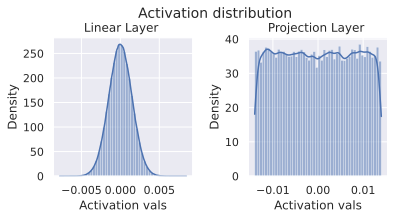

Linear Layer - Variance: 2.2128833734313957e-06
Projection Layer - Variance: 6.59050710964948e-05


In [56]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
            param.data.uniform_(-bound, bound)


xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

In [62]:
logger = TensorBoardLogger("runs", name="CBOW Model")
model = W2V_CBOW(tokenizer=tokenizer)
equal_var_init(model)
trainer = L.Trainer(logger=logger, max_epochs=1)
trainer.fit(model=model, train_dataloaders=test_dl, val_dataloaders=test_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type      | Params | Mode 
-------------------------------------------------------
0 | projection_layer | Embedding | 15.4 M | train
1 | linear_layer     | Linear    | 15.4 M | train
-------------------------------------------------------
30.8 M    Trainable params
0         Non-trainable params
30.8 M    Total params
123.000   Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 344/344 [00:31<00:00, 11.00it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 344/344 [00:31<00:00, 10.78it/s, v_num=2]


In [ ]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 1667), started 2:11:38 ago. (Use '!kill 1667' to kill it.)